In [1]:
from congress_utils import congress_clsna, preprocess_congress_2, make_ar_pair, member_dict, ClsnaModelCongress
from utils import visualize_membership, visualize
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes


In [2]:
import time

In [3]:
DIM = 2
SIGMA = 10
TAU = 1
PHI = 10
T=11

In [4]:
import numpy as np
from scipy.spatial.distance import squareform
from sklearn.preprocessing import normalize
from scipy.sparse.csgraph import laplacian
import torch


#names [array(['biden','sanders',...]),...]
names = []
for i in range(1,12):
    names.append(list(np.load('name'+str(i)+'.npy')))
#Y [array Y1,...]
Y = []
for i in range(1,12):
    Y.append(np.load('Y'+str(i)+'.npy'))

real_name = list(np.load("real_name.npy"))
handle = list(np.load('handle.npy'))
party_id =(np.load('party_id.npy'))

party_id = list(np.where(party_id == 'D', 0, 1))

#membership [['D','R',...],...]
membership = []
for i in range(T):
    mem = []
    for name in names[i]:
        mem.append(party_id[handle.index(name)])
    membership.append(mem)

time_point = []
n_nodes = []
start_idx = 0
for arr in names:
    n_nodes.append(len(arr))
    time_point.append(np.arange(start_idx, start_idx + len(arr)))
    start_idx += len(arr)
# time_point: [array([0, 1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])]

def process_arrays(t):
    index_pairs = []
    not_in_name1 = {0:[],1:[]}
    name1 = names[t-1]
    name2 = names[t]

    for i, name in enumerate(name2):
        if name in name1:
            j = name1.index(name)
            index_pairs.append((time_point[t-1][j],time_point[t][i]))
        else:
            party = party_id[handle.index(name)]
            if party not in not_in_name1:
                not_in_name1[party] = []
            not_in_name1[party].append(time_point[t][i])

    return index_pairs, not_in_name1

# # Example usage:
# handle = ["Alice", "Bob", "Charlie", "David", "Eva"]
# party_id = ["A", "B", "A", "B", "A"]
# name1 = ["Alice", "David", "Eva"]
# name2 = ["Eva","Charlie", "Bob","David"]

# index_pairs, grouped_by_party = process_arrays(handle, party_id, name1, name2)
# print("Index pairs:", index_pairs)
# print("Grouped by party:", grouped_by_party)

# #Output
# Index pairs: [(0, 2), (3, 1)]
# Grouped by party: {'A': ['Charlie'], 'B': ['Bob']}

#ar_pair, a T-1 element list of Nx2 array, each row of array is [prev,self]
ar_pair = []
#new_at_t, a T-1 element dict, key is time, each element is also dict, key is party name
new_at_t = {}
for i in range(1,T):
    index_pairs, grouped_by_party = process_arrays(i)
    ar_pair+=index_pairs
    new_at_t[i] = grouped_by_party


def group_by_party(t):
    parties = membership[t]
    party_groups = {}
    
    for i, party in enumerate(parties):
        if party not in party_groups:
            party_groups[party] = []

        party_groups[party].append(time_point[t][i])

    return party_groups

# names = ['John Doe', 'Jane Smith', 'Mike Johnson', 'Sara Brown']
# parties = ['Democrat', 'Republican', 'Democrat', 'Republican']

# result = group_by_party(names, parties)
# print(result)
# {'Democrat': [0, 2], 'Republican': [1, 3]}

member_at_t = {}
for i in range(T):
    member_at_t[i] = group_by_party(i)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

import torch
def convert_to_tensor(data, device):
    return torch.tensor(data, dtype=torch.long, device=device)
def party_dict_to_tensor(party_dict,device):
    return {party:convert_to_tensor(indices,device) for party,indices in party_dict.items()}
    

ar_pair = convert_to_tensor(ar_pair,device)
member_at_t = {year: party_dict_to_tensor(p_dict,device) for year, p_dict in member_at_t.items()}
new_at_t = {year: party_dict_to_tensor(p_dict,device) for year, p_dict in new_at_t.items()}


def find_matching_indices(name1, name2):
    matching_indices = []
    for i, name in enumerate(name1):
        if name in name2:
            j = name2.index(name)
            matching_indices.append([i, j])
    return np.array(matching_indices)

def extract_subgraph_adjacency_matrix(Y_t1, matching_indices, Y_t2):
    size = Y_t2.shape[0]
    persist = np.zeros((size, size))
    i = matching_indices[:,0]
    j = matching_indices[:,1]
    persist[np.ix_(j, j)] = Y_t1[np.ix_(i, i)]
    return persist
def construct_persistence(t):
    matching_indices = find_matching_indices(names[t-1], names[t])
    persist = extract_subgraph_adjacency_matrix(Y[t-1], matching_indices, Y[t])
    return persist
persist = []
for i in range(1,T):
    persist.append(squareform(construct_persistence(i)))

y_t = squareform(Y[0])
y = [y_t]
Aw = []
Aw2 = []
Ab = []
s=np.array(membership[0])
for i in range(1,T):
    #normalized graph laplalcian by row
    Aw_t = squareform(y_t)*(np.outer(s, s))
    Aw_t = -2*normalize(laplacian(Aw_t), axis=1, norm='l1')
    Aw2_t = squareform(y_t)*(np.outer(1-s, 1-s))
    Aw2_t = -2*normalize(laplacian(Aw2_t), axis=1, norm='l1')
    Ab_t = squareform(y_t)*(np.outer(1-s, s)+np.outer(s, 1-s))
    Ab_t = -2*normalize(laplacian(Ab_t), axis=1, norm='l1')
    y_t = squareform(Y[i])
    s=np.array(membership[i])
    #save
    y.append(y_t)
    Aw.append(Aw_t)
    Aw2.append(Aw2_t)
    Ab.append(Ab_t)

In [5]:
density = []
for network in Y:
    density.append(np.mean(network))

In [6]:
density

[0.016435409962362268,
 0.0856692201269373,
 0.13066954034337427,
 0.174812614847292,
 0.22999224376731303,
 0.2713090331922477,
 0.33915311292465944,
 0.3297333193526965,
 0.3278167222567697,
 0.31282151290268173,
 0.354934755146788]

In [7]:
R_list = []
D_list = []
for mem in membership:
    R_list.append(np.sum(mem))
    D_list.append(len(mem)-np.sum(mem))

In [8]:
R_list

[162, 231, 225, 259, 250, 297, 285, 309, 287, 315, 256]

In [9]:
D_list

[191, 200, 196, 232, 225, 239, 226, 252, 245, 301, 283]

In [10]:
# for i in range(1,12):
#     np.save('../compare/name'+str(i)+'.npy', names[i-1])

In [11]:
persist = np.concatenate(persist)

In [12]:
label, persist, Aw, Aw2, Ab, combination_N=preprocess_congress_2(y, Aw, Aw2,Ab, n_nodes, persist)

In [13]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

In [14]:
combination_N = combination_N.to(device)
label = label.to(device)
persist = persist.to(device)

In [15]:
LR = 2e-3
MOM = 0.99
LR_P = 1e-2

In [16]:
np.sum(n_nodes)

5466

In [17]:
n_nodes[0]

353

# Step 1

In [18]:
def train(optimizer,index=None, fixed=None):
    t_index=torch.arange(start=0,end=np.sum(n_nodes),device=device,requires_grad=False)
    optimizer.zero_grad()
    loss = model.loss(device=device,label=label,persist=persist,sample_edge=combination_N,T_index=t_index,ss=SIGMA,tt=TAU,pp=PHI)
    loss.backward()
    model.para.grad = 0.1*((model.para.grad>0).bool().float()-0.5)
    optimizer.step()
    if index is not None:
        with torch.no_grad():
            model.para[index[0],index[1]] = fixed
    return loss.item()

In [19]:
def run(optimizer):
    for epoch in range(1,3000):
        loss = train(optimizer)
        if epoch%300==0:
            print(loss)

In [20]:
model = ClsnaModelCongress(device,n_nodes,T,ar_pair,Aw,Aw2,Ab,new_at_t,member_at_t,D=DIM+1).to(device)

In [21]:
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": 0.99, "lr": 0.02},
    {'params': model.para, "momentum": 0, "lr":1e-1}
    ])

In [22]:
run(optimizer)

352199.74947305897
253874.077482373
223486.43928205202
220086.0309039147
230648.48137095367
237369.888249736
239767.61465666536
237906.65473962517
231770.32490133398


In [23]:
model.para

Parameter containing:
tensor([[14.9953,  4.6551],
        [14.9953, -0.0750],
        [-0.1250,  0.9350],
        [ 0.4550, 14.9953]], requires_grad=True)

In [24]:
print(torch.pca_lowrank(model.z.cpu())[1])
PCA_p = torch.pca_lowrank(model.z.cpu())[2][:,[0,1]]
zz=(model.z.cpu().detach()@PCA_p).detach().numpy()
init_z = zz
init_para = model.para.detach().cpu().numpy()

tensor([470.2484, 448.9973, 418.0535], grad_fn=<LinalgSvdBackward0>)


In [25]:
zz = np.clip(zz, -15, 15)

# Step 2

In [26]:
model = ClsnaModelCongress(device,n_nodes,T,ar_pair,Aw,Aw2,Ab,new_at_t,member_at_t,D=DIM).to(device)
with torch.no_grad():       
    model.z[:,:] = torch.from_numpy(init_z).to(device)
    model.para[:,:] = torch.from_numpy(init_para).to(device)
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": 0.99, "lr": 0.02},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])

In [27]:
def run(optimizer):
    for epoch in range(1,3000):
#         optimizer.param_groups[0]['lr'] = 0.0005
        loss = train(optimizer)
        if epoch%300==0:
            print(loss)
            print(model.para)           

In [28]:
run(optimizer)

235326.33152400766
Parameter containing:
tensor([[15.1452,  4.5080],
        [15.1452, -0.1110],
        [-0.1810,  0.7990],
        [ 0.3300, 15.1452]], requires_grad=True)
228870.04448605562
Parameter containing:
tensor([[15.2951,  4.3579],
        [15.2951, -0.1280],
        [-0.1760,  0.7130],
        [ 0.2990, 15.2951]], requires_grad=True)
227431.807169226
Parameter containing:
tensor([[15.4450,  4.2079],
        [15.4450, -0.1310],
        [-0.1800,  0.7630],
        [ 0.3040, 15.4450]], requires_grad=True)
226392.12560020175
Parameter containing:
tensor([[15.5950,  4.0578],
        [15.5950, -0.1300],
        [-0.1840,  0.8100],
        [ 0.3060, 15.5950]], requires_grad=True)
225516.75240901482
Parameter containing:
tensor([[15.7449,  3.9078],
        [15.7449, -0.1270],
        [-0.1890,  0.8590],
        [ 0.3090, 15.7449]], requires_grad=True)
224798.5392554087
Parameter containing:
tensor([[15.8948,  3.7578],
        [15.8948, -0.1250],
        [-0.1930,  0.9080],
        

In [29]:
run(optimizer)

223621.42219151813
Parameter containing:
tensor([[16.6439,  3.2234],
        [16.6439, -0.1125],
        [-0.2135,  1.0855],
        [ 0.3285, 16.6439]], requires_grad=True)
223621.15909348763
Parameter containing:
tensor([[16.7938,  3.2234],
        [16.7938, -0.1125],
        [-0.2135,  1.0855],
        [ 0.3285, 16.7938]], requires_grad=True)
223621.14743836527
Parameter containing:
tensor([[16.9437,  3.2234],
        [16.9437, -0.1125],
        [-0.2135,  1.0855],
        [ 0.3285, 16.9437]], requires_grad=True)


KeyboardInterrupt: 

In [30]:
zz = model.z.cpu().detach().numpy()

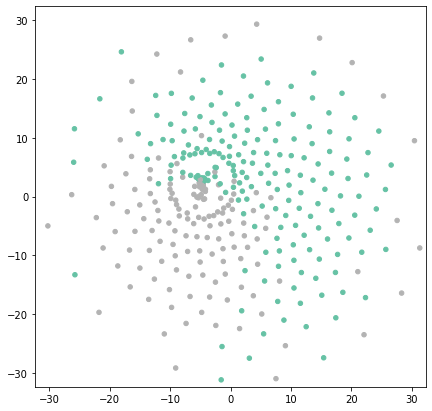

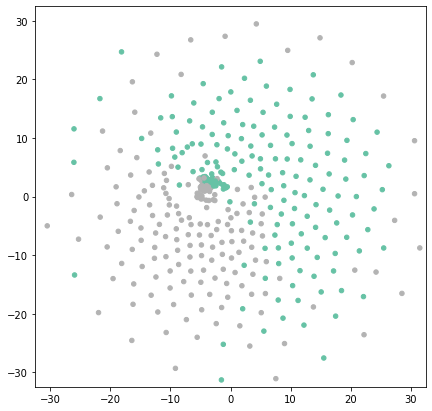

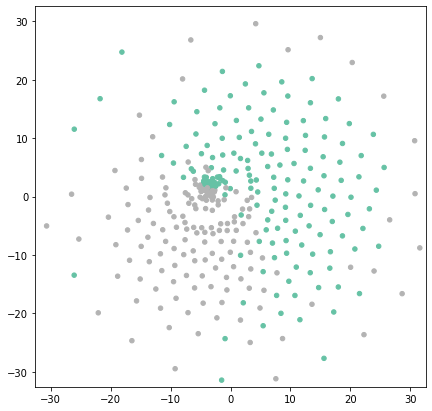

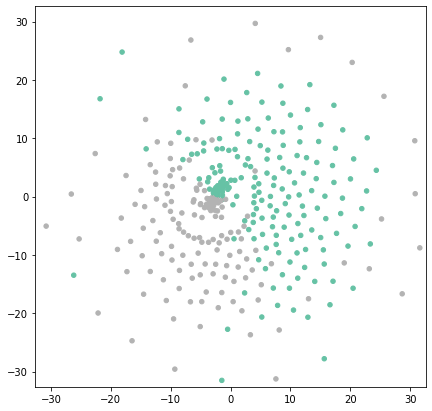

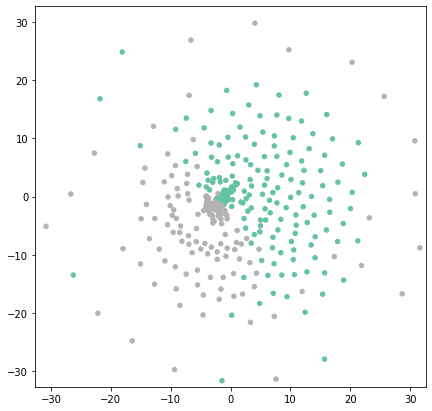

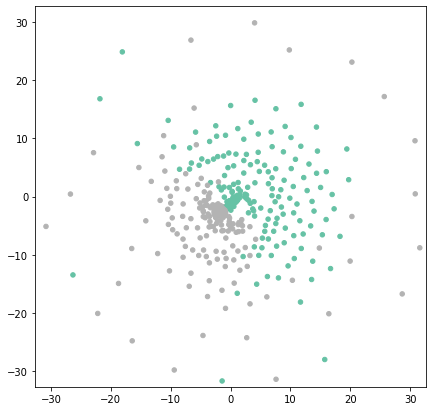

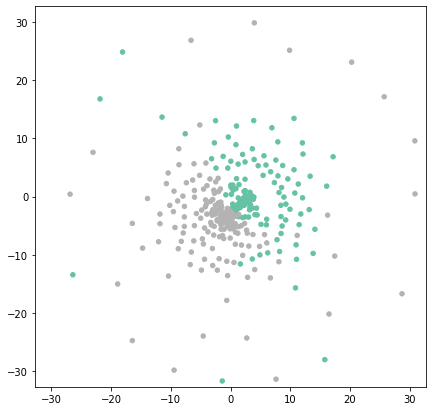

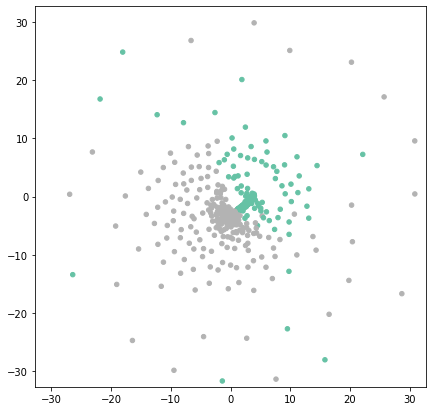

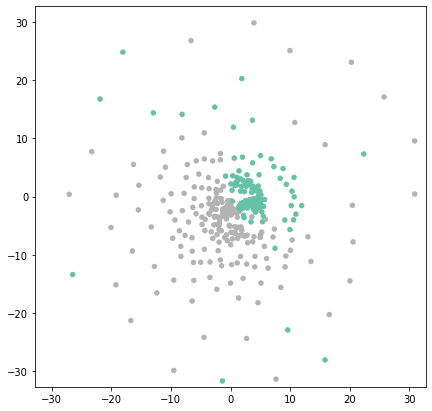

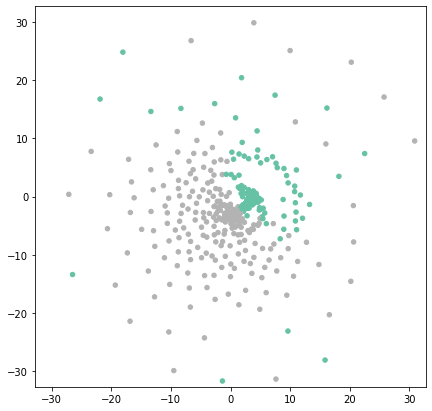

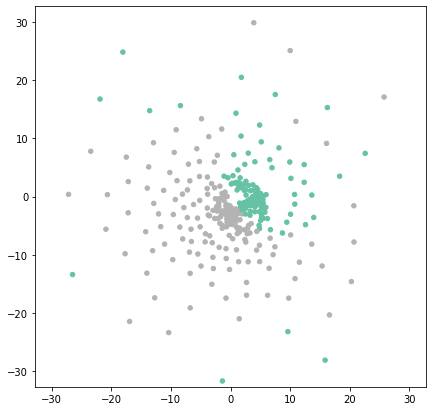

In [31]:
for i in range(T):
    start = int(np.sum(n_nodes[:i]))
    end = int(np.sum(n_nodes[:(i+1)]))
#     visualize(z_hat=zz,z_true=zz,start=start,end=end)
    visualize_membership(zz,np.concatenate(membership),start,end,caption=None)

In [32]:
init_z = zz
init_para = model.para.detach().cpu().numpy()

In [33]:
# np.save('../compare/z6.npy', init_z)

In [34]:
init_para

array([[16.967213  ,  3.2228506 ],
       [16.967213  , -0.11300008],
       [-0.21399888,  1.0849962 ],
       [ 0.32800138, 16.967213  ]], dtype=float32)

# Step 3

In [35]:
def run(optimizer,index,fixed):
    for epoch in range(1,2000):
        loss = train(optimizer=optimizer,index=index,fixed=fixed)
        if epoch%500 == 0:
            print(loss)
    return loss

In [36]:
model = ClsnaModelCongress(device,n_nodes,T,ar_pair,Aw,Aw2,Ab,new_at_t,member_at_t,D=DIM).to(device)
with torch.no_grad():       
    model.z[:,:] = torch.from_numpy(init_z).to(device)
    model.para[:,:] = torch.from_numpy(init_para).to(device)
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": 0.99, "lr": 0.02},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])    
logL = train(optimizer)

In [37]:
delta_var = 0.1

In [38]:
# parad = {'alpha':(0,1),'delta':(2,1),'gw':(1,1),'gw2':(3,0),'gb':(2,0)}
# var_list = []
# for key, value in parad.items():
#     model = ClsnaModelCongress(device,n_nodes,T,ar_pair,Aw,Aw2,Ab,new_at_t,member_at_t,D=DIM).to(device)
#     with torch.no_grad():       
#         model.z[:,:] = torch.from_numpy(init_z).to(device)
#         model.para[:,:] = torch.from_numpy(init_para).to(device)
#     optimizer = torch.optim.SGD([
#     {'params': model.z, "momentum": 0.99, "lr": 0.02},
#     {'params': model.para, "momentum": 0.0, "lr":LR_P}
#     ])
#     newlogL=run(optimizer,value,init_para[value[0],value[1]]+delta_var)
#     print("--------------------------------")
#     var_hat = delta_var/(newlogL-logL)**0.5/2**0.5
#     print(key,var_hat)
#     var_list.append(round(var_hat,4))

In [39]:
parad = {'alpha':(0,1),'delta':(2,1),'gw':(1,1),'gw2':(3,0),'gb':(2,0)}
var_list = []
cov_list = []

for key, value in parad.items():
    model = ClsnaModelCongress(device,n_nodes,T,ar_pair,Aw,Aw2,Ab,new_at_t,member_at_t,D=DIM).to(device)
    with torch.no_grad():       
        model.z[:,:] = torch.from_numpy(init_z).to(device)
        model.para[:,:] = torch.from_numpy(init_para).to(device)
    optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": 0.99, "lr": 0.02},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])
    newlogL=run(optimizer,value,init_para[value[0],value[1]]+delta_var)
    var_hat = delta_var/(newlogL-logL)**0.5/2**0.5
    var_list.append(round(var_hat,5))
    
    diff = model.para-torch.from_numpy(init_para).to(device)
    extracted_values = [diff[value[0], value[1]].item() for value in parad.values()]
    extracted_values = np.array(extracted_values)
    cov_list.append(extracted_values/delta_var*var_hat**2)

223665.59585359396
223664.42127663255
223664.3986166434
223671.3605193517
223671.02662830276
223670.8848812311
223651.37059505782
223651.17262209766
223651.0632519494
223636.07666322502
223635.881913803
223635.79704110432
223693.67952662057
223693.49207148093
223693.3622874989


In [40]:
(np.array(cov_list)*10000).round(2)

array([[ 1.16, -0.38, -0.02, -0.03,  0.05],
       [-0.4 ,  1.02,  0.06,  0.07, -0.04],
       [-0.06,  0.06,  1.72,  0.32, -0.53],
       [-0.02,  0.05,  0.34,  3.61, -0.52],
       [ 0.01, -0.02, -0.5 , -0.44,  0.69]])

In [41]:
cov_m = np.array(cov_list)

In [42]:
#gammaw1-gammaw2
(cov_m[2,2]+cov_m[3,3]-cov_m[2,3]-cov_m[3,2])**0.5

0.02160310452632058

In [43]:
#gammaw1-gammab
(cov_m[2,2]+cov_m[4,4]-cov_m[2,4]-cov_m[4,2])**0.5

0.018547060240576528

In [44]:
#gammaw2-gammab
(cov_m[3,3]+cov_m[4,4]-cov_m[3,4]-cov_m[4,3])**0.5

0.022943267529820628

In [45]:
#gammaw1+gammab
(cov_m[2,2]+cov_m[4,4]+cov_m[2,4]+cov_m[4,2])**0.5

0.011812946912397058

In [46]:
#gammaw2+gammab
(cov_m[3,3]+cov_m[4,4]+cov_m[3,4]+cov_m[4,3])**0.5

0.01826496012802315

In [47]:
var_list

[0.01077, 0.01012, 0.01313, 0.01899, 0.00834]

In [ ]:
init_para = init_para.round(3)
printdict = {'a':init_para[0,1],'d':init_para[2,1],'gw':init_para[1,1],'gw2':init_para[3,0],'gb':init_para[2,0]}
print(printdict)

In [ ]:
for i in range(T-1):
#     corr = zz[N*i:N*(i+1)].transpose()@zz[N*(i+1):N*(i+2)]
#     print(corr.round(1))
    d1=zz[N*i:N*(i+1)]
    d2=zz[N*(i+1):N*(i+2)]
    c1=d1-(d1.mean(axis=0))[np.newaxis,:]
    c2=d2-(d2.mean(axis=0))[np.newaxis,:]
    R,_ = orthogonal_procrustes(c1,c2)
    print(np.diag(R).round(2))

In [ ]:
import csv   
fields=var_list
with open('var001', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

In [ ]:
import csv   
fields=list(printdict.values())
with open('theta001', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)